# Questions of PyTorch Geometric Temporal

SEOYEON CHOI  
2023-05-04

> PyTorch Geometric Temporal

# PyTorch Geometric Temporal: Spatiotemporal Signal Processing with Neural Machine Learning Models

Reference: [Paper](https://arxiv.org/pdf/2104.07788.pdf),
[Website](https://pytorch-geometric-temporal.readthedocs.io/en/latest/notes/introduction.html?highlight=web#web-traffic-prediction)

## Applications

### Epidemiological Forecasting

In [1]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [3]:
from tqdm import tqdm

model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
###########################################################
# I added this to check the shape.
print(y_hat.shape,snapshot.y.shape,(y_hat-snapshot.y).shape)

100%|██████████| 200/200 [02:40<00:00,  1.24it/s]

torch.Size([20, 1]) torch.Size([20]) torch.Size([20, 20])

In [4]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))
# >>> MSE: 1.0232

MSE: 1.0247

------------------------------------------------------------------------

#### Shape Check (1)

In [5]:
a = torch.randn(20, 1)

In [6]:
b = torch.randn(20)

In [7]:
c = a-b

In [8]:
print(a.size(),b.size(),c.size())

torch.Size([20, 1]) torch.Size([20]) torch.Size([20, 20])

------------------------------------------------------------------------

#### Doesn’t it have to ‘y_hat’ be the same shape as snapshot.y?

-   If we want to compare the y_hat from the model with the values y,
    the same shape is appropriate to evaluate.

In [9]:
from tqdm import tqdm

model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).reshape(-1)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
###########################################################
# I added this to check the shape.
print(y_hat.shape,snapshot.y.shape,(y_hat-snapshot.y).shape)

100%|██████████| 200/200 [01:27<00:00,  2.30it/s]

torch.Size([20]) torch.Size([20]) torch.Size([20])

In [10]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))
# >>> MSE: 1.0232

MSE: 1.2844

------------------------------------------------------------------------

#### Shape Check (2)

In [26]:
a = torch.randn(20, 1).reshape(-1)

In [27]:
b = torch.randn(20)

In [28]:
c = a-b

In [29]:
print(a.size(),b.size(),c.size())

torch.Size([20]) torch.Size([20]) torch.Size([20])

------------------------------------------------------------------------

## Web Traffic Prediction

In [11]:
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=14)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [13]:
from tqdm import tqdm

model = RecurrentGCN(node_features=14, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    
###########################################################
# I added this to check the shape.
print(y_hat.shape,snapshot.y.shape,(y_hat-snapshot.y).shape)

100%|██████████| 50/50 [31:26<00:00, 37.73s/it]

torch.Size([1068, 1]) torch.Size([1068]) torch.Size([1068, 1068])

In [14]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))
# >>> MSE: 0.7760

MSE: 0.7939

------------------------------------------------------------------------

#### Shape Check (1)

In [20]:
a = torch.randn(1068, 1)

In [21]:
b = torch.randn(1068)

In [22]:
c = a-b

In [23]:
print(a.size(),b.size(),c.size())

torch.Size([1068, 1]) torch.Size([1068]) torch.Size([1068, 1068])

------------------------------------------------------------------------

#### If the code changes the shape of y_hat?

In [24]:
from tqdm import tqdm

model = RecurrentGCN(node_features=14, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    
###########################################################
# I added this to check the shape.
print(y_hat.shape,snapshot.y.shape,(y_hat-snapshot.y).shape)

100%|██████████| 50/50 [36:39<00:00, 43.99s/it]

torch.Size([1068, 1]) torch.Size([1068]) torch.Size([1068, 1068])

In [25]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))
# >>> MSE: 0.7760

MSE: 0.7807

------------------------------------------------------------------------

#### Shape Check (2)

In [30]:
a = torch.randn(1068, 1).reshape(-1)

In [31]:
b = torch.randn(1068)

In [32]:
c = a-b

In [33]:
print(a.size(),b.size(),c.size())

torch.Size([1068]) torch.Size([1068]) torch.Size([1068])

------------------------------------------------------------------------

Fix :
https://github.com/benedekrozemberczki/pytorch_geometric_temporal/issues/231

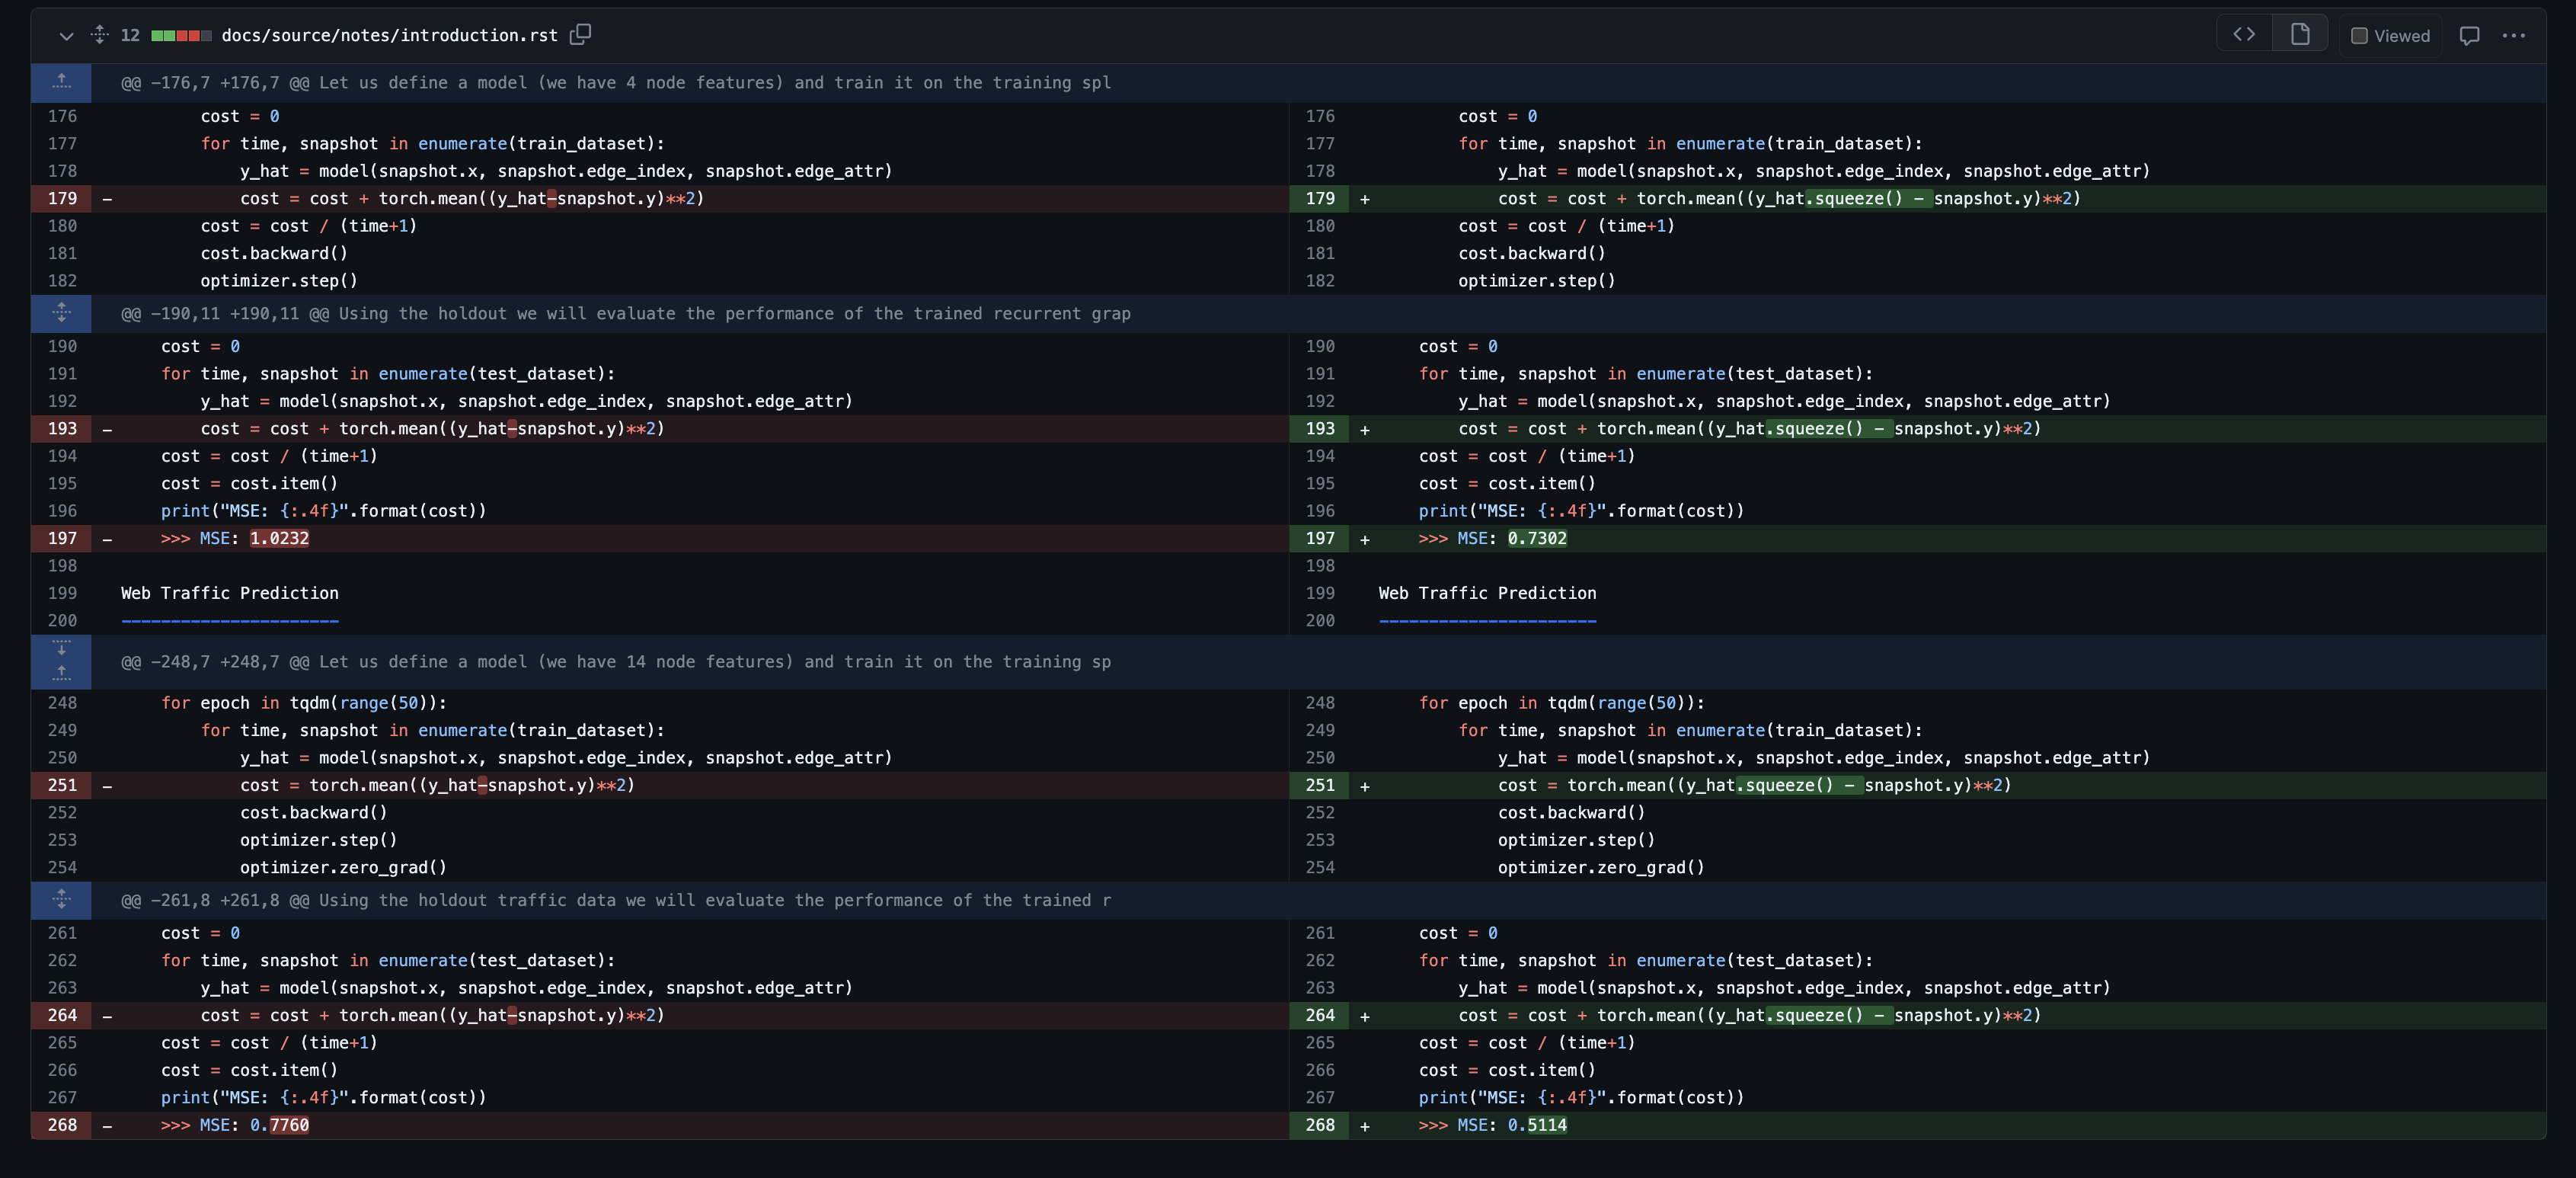

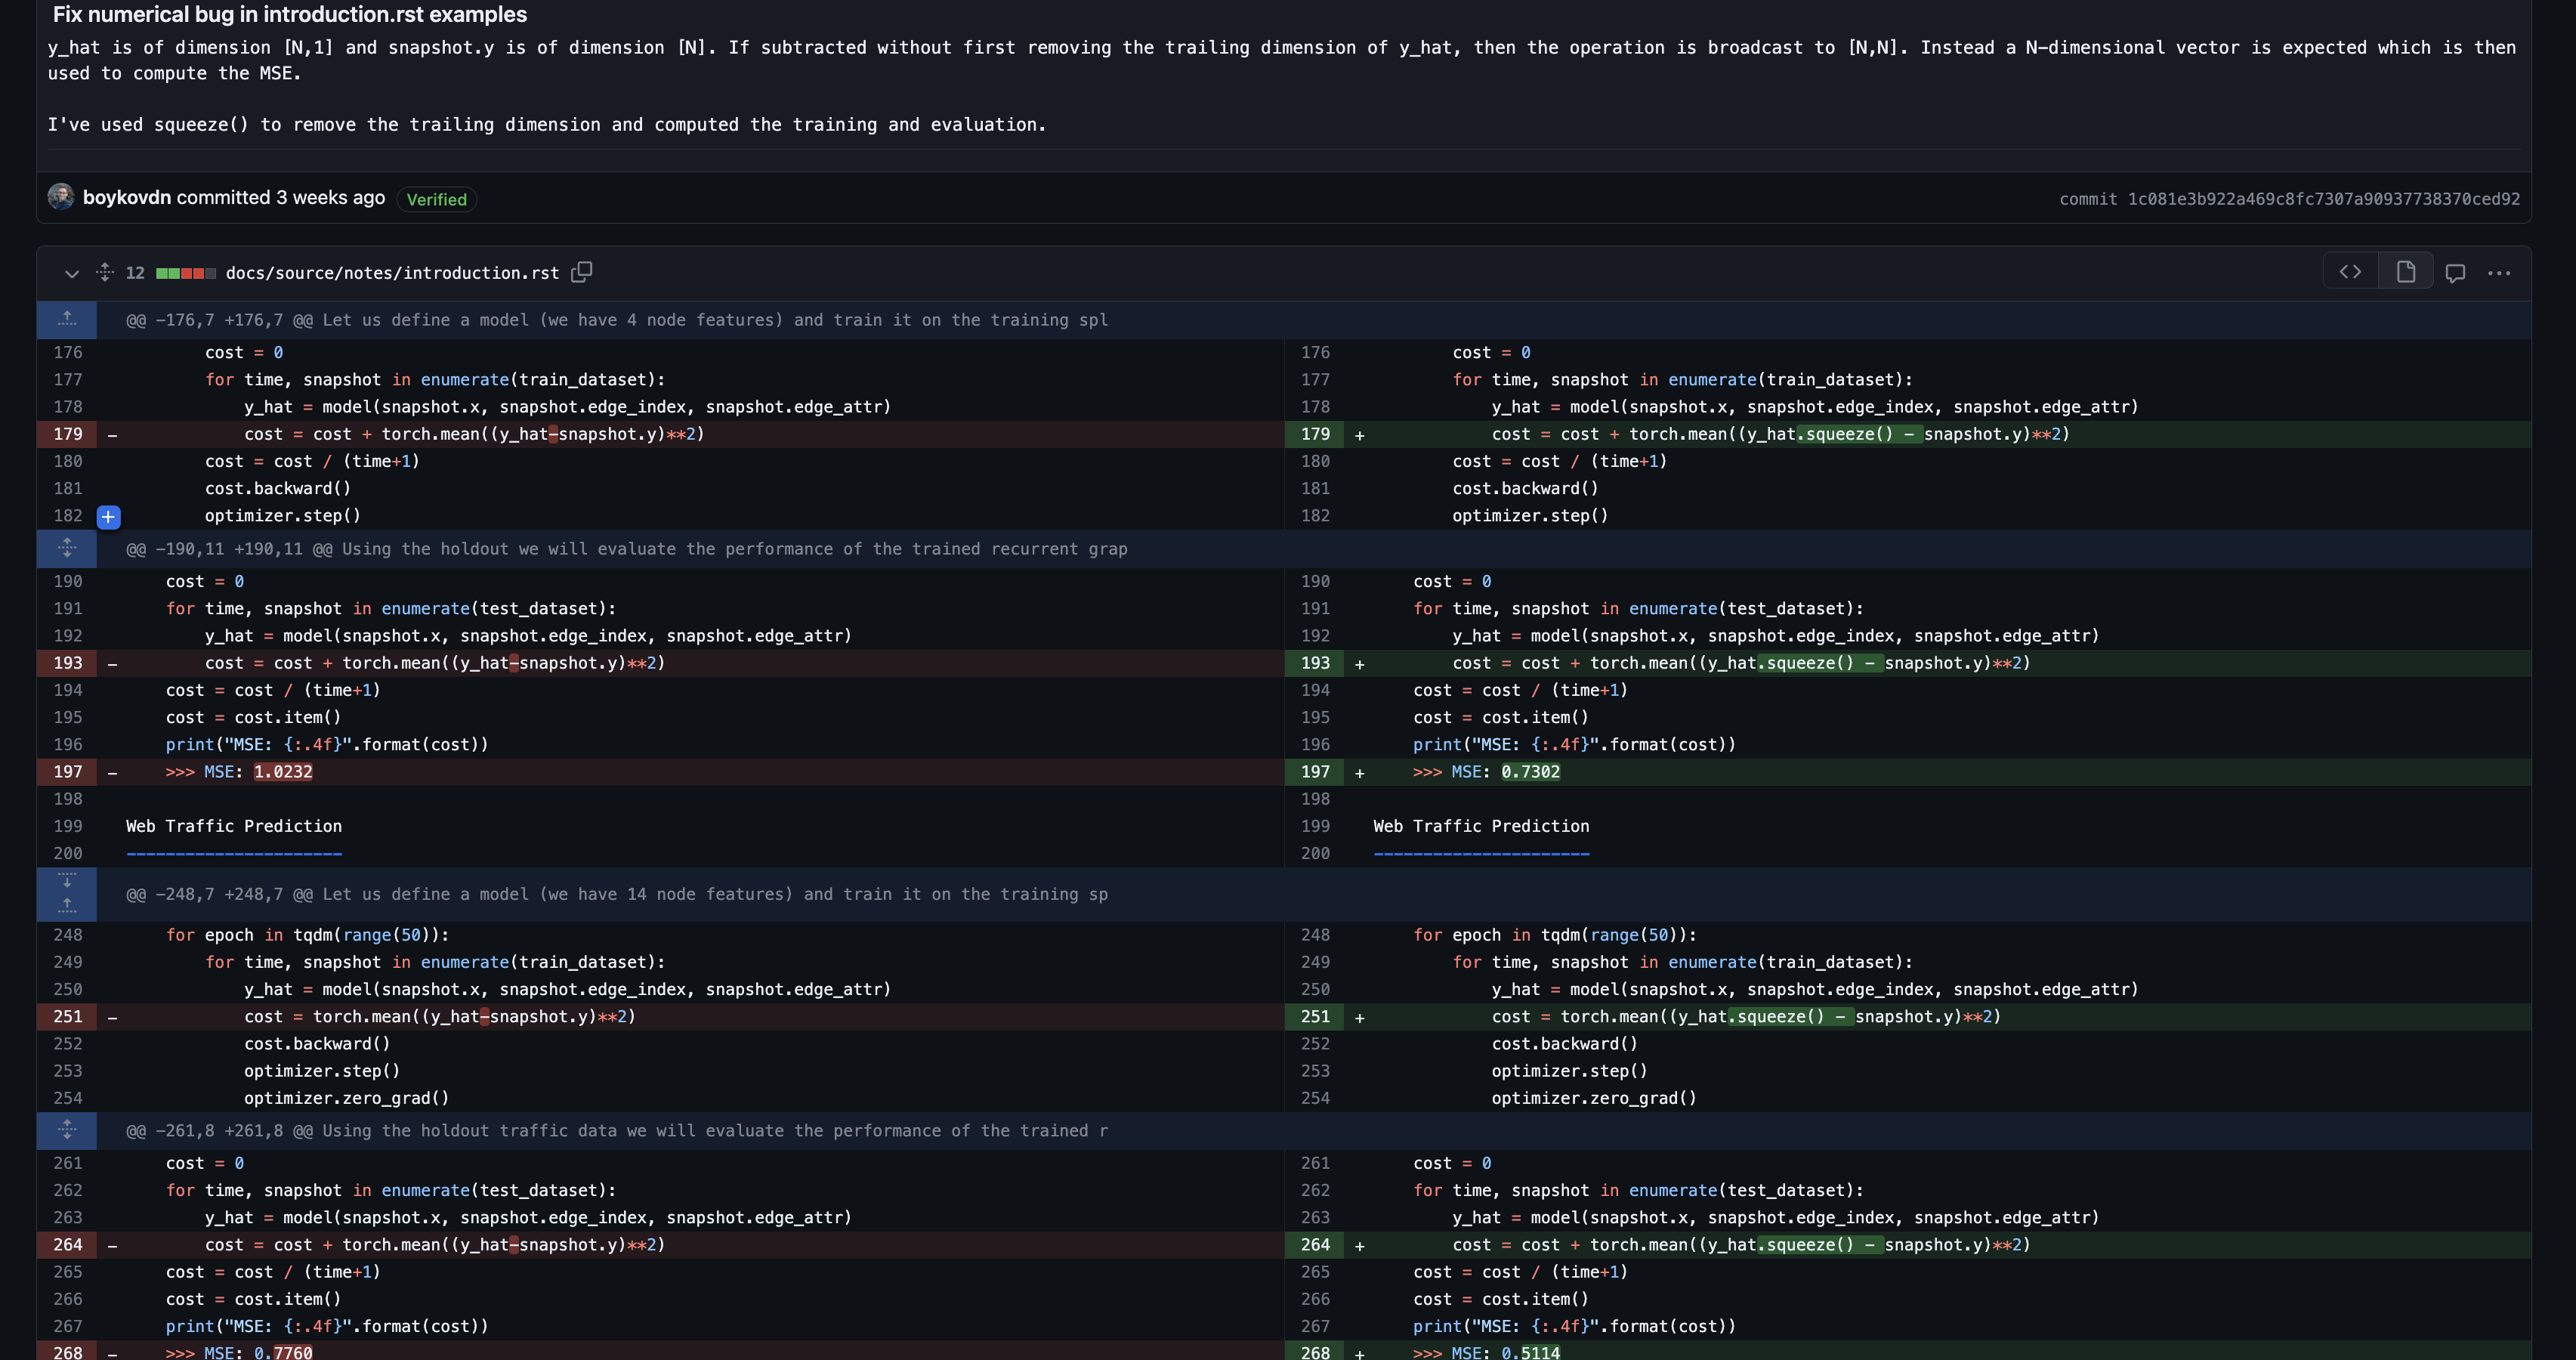

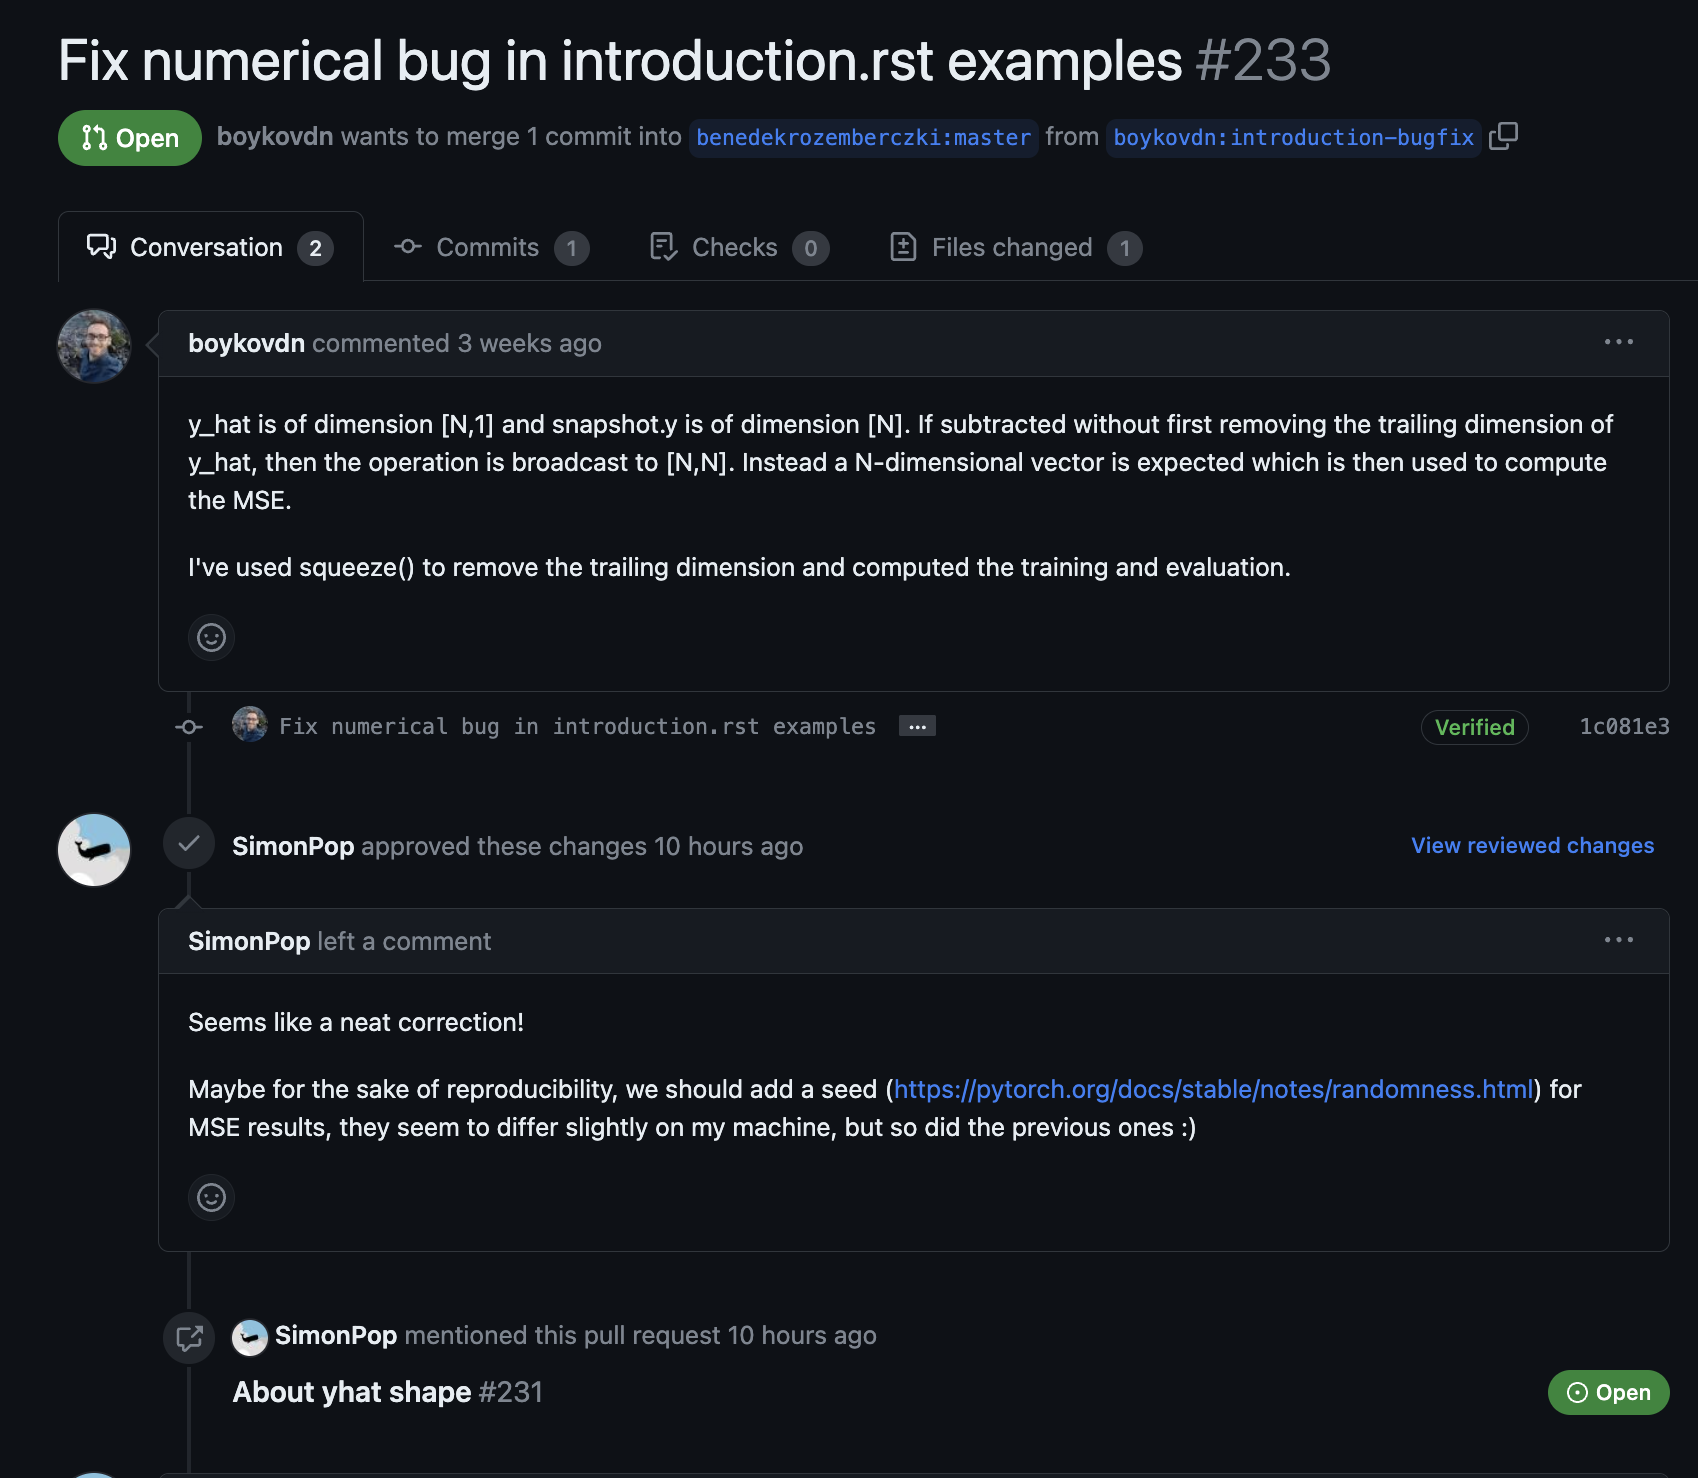